## Natural Language Processing (INM434) Coursework
## Best Models- Random Forest Classifier and BERT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

In [3]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Dataset- https://huggingface.co/datasets/rkf2778/amazon_reviews_mobile_electronics

In [ ]:
!pip3 install datasets

In [ ]:
from datasets import load_dataset
df = load_dataset("rkf2778/amazon_reviews_mobile_electronics")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



In [ ]:
df.set_format(type='pandas', columns=['review_body','star_rating','star_rating_label'])
train=pd.DataFrame(df['train'][:])
test=pd.DataFrame(df['test'][:])

#dropping rows with misisng values
train.dropna(axis=0,inplace=True)
train.reset_index(drop=True,inplace=True)
train.isna().sum()

## Data Preprocessing

In [ ]:
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    # Apply stemming and remove stopwords
    review = [ps.stem(word) for word in review
                if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    return review

import time
t=time.time()
# Train dataset
train['cleaned_review'] = train['review_body'].apply(preprocess_text).tolist()
# Test dataset
test['cleaned_review'] = test['review_body'].apply(preprocess_text)
print("Elapsed Time-",time.time()-t)

Elapsed Time- 546.9214103221893


In [ ]:
#Mapping the star rating values to 1 or 0

dict = {'positive':1,'negative':0}
train=train.replace({"star_rating_label": dict})
test=test.replace({"star_rating_label": dict})

train.head()

,star_rating,review_body,star_rating_label,cleaned_review
0,5,Item was as discribed ; was shipped fast and f...,1,item discrib ship fast function well would busi
1,5,Came in perfect. Works perfectly,1,came perfect work perfectli
2,2,"Good quality, came with out the extra boom mic...",0,good qualiti came extra boom mic cushion cord ...
3,5,I do not like reading my Kindle in a case so t...,1,like read kindl case sleev great good protect ...
4,5,The case came 3 days after I ordered it. It fi...,1,case came day order fit ipod realli well color...


In [ ]:
corpus_train=[]
corpus_test=[]
for i in range(len(train)):
    corpus_train.append(train['cleaned_review'][i])
for i in range(len(test)):
    corpus_test.append(test['cleaned_review'][i])

## Baseline Model 1: RandomForestClassifier

In [ ]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=1500,ngram_range=(1, 4))

# X contains corpus (dependent variable)
X_train = cv.fit_transform(corpus_train)
X_test = cv.fit_transform(corpus_test)

# y contains answers if review
# is positive or negative
y_train = train['star_rating_label'].values
y_test = test['star_rating_label'].values

In [ ]:
X_train.shape

(68903, 1500)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

# Initialize TfidfTransformer
tfidf_transformer = TfidfTransformer()

# Fit TfidfTransformer on the training data and transform both train and test data
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.transform(X_test)

# Now X_train_tfidf and X_test_tfidf contain TF-IDF representations of the training and test data respectively

# Optionally, you can also convert sparse matrix to numpy array if needed
X_train_tfidf_array = X_train_tfidf.toarray()
X_test_tfidf_array = X_test_tfidf.toarray()

In [ ]:
len(X_train_tfidf_array),len(y_train)

(68903, 68903)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Fitting Random Forest Classification
# to the Training set
from sklearn.ensemble import RandomForestClassifier

# n_estimators can be said as number of
# trees, experiment with n_estimators
# to get better results
model = RandomForestClassifier(n_estimators = 300,max_depth=30,
                            criterion = 'entropy')

import time
t=time.time()
model.fit(X_train_tfidf_array, y_train)
print("Elapsed Time-",time.time()-t)

Elapsed Time- 404.96255803108215


In [ ]:
y_pred = model.predict(X_test_tfidf_array)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 67.66%


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.16      0.26      5901
           1       0.68      0.94      0.79     11326

    accuracy                           0.68     17227
   macro avg       0.64      0.55      0.53     17227
weighted avg       0.66      0.68      0.61     17227



Text(50.722222222222214, 0.5, 'True labels')

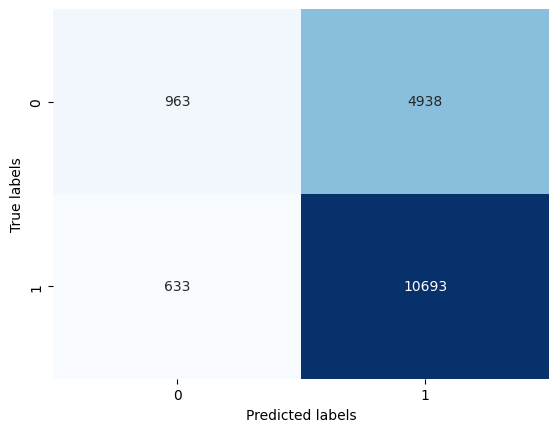

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [ ]:
test_size=17227
tp=(10693/test_size)*100
tn=(963/test_size)*100
fp=(4938/test_size)*100
fn=(633/test_size)*100
print(f"True positive: {tp}, True Negative: {tn}, False Positive: {fp}, False Negative:{fn}")

True positive: 62.071167353572875, True Negative: 5.590062111801243, False Positive: 28.664306031230048, False Negative:3.674464503395832


## Model 1: BERT

In [ ]:
test.head()

,star_rating,review_body,star_rating_label,cleaned_review
0,5,This was just the right product I needed when ...,1,right product need travel best price go wrong
1,5,I love it! its pretty bulky but that's why I g...,1,love pretti bulki got littl brighter green pic...
2,1,I purchased 2. Neither of them work if you wis...,0,purchas neither work wish throw money away get...
3,1,It's like watching an old Japanese monster mov...,0,like watch old japanes monster movi sound sync...
4,5,"Maybe I'm easily impressed, but this tiny cube...",1,mayb easili impress tini cube realli great put...


In [ ]:
x_val, x_test, y_val, y_test = train_test_split(test['cleaned_review'],test['star_rating_label'],test_size=0.5, stratify = test['star_rating_label'])


In [ ]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(train['cleaned_review'].tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [ ]:
# Intializing the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compiling the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# Training the model
t=time.time()
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    train['star_rating_label'],
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=3
)
print("Elapsed Time-",time.time()-t)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2154/2154 [==============================] - 2047s 902ms/step - loss: 0.3849 - accuracy: 0.8248 - val_loss: 0.3324 - val_accuracy: 0.8532
Epoch 2/3
2154/2154 [==============================] - 1931s 896ms/step - loss: 0.2942 - accuracy: 0.8755 - val_loss: 0.3287 - val_accuracy: 0.8658
Epoch 3/3
2154/2154 [==============================] - 1932s 897ms/step - loss: 0.2279 - accuracy: 0.9076 - val_loss: 0.3325 - val_accuracy: 0.8682
Elapsed Time- 5910.398844242096


In [ ]:
# Testing the model
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

270/270 [==============================] - 79s 221ms/step - loss: 0.3251 - accuracy: 0.8711
Test loss: 0.32507121562957764, Test accuracy: 0.8711400032043457


In [ ]:
from scipy.special import softmax
# Predict labels for the test set
y_pred_logits = model.predict([X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']]).logits
y_pred_probs = softmax(y_pred_logits, axis=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Identify misclassified instances
misclassified_indices = np.where(y_pred != y_test)[0]

# Retrieve misclassified reviews and their true and predicted labels
misclassified_reviews = x_test.iloc[misclassified_indices]
true_labels = y_test.iloc[misclassified_indices]
predicted_labels = y_pred[misclassified_indices]

# Print out misclassified reviews along with true and predicted labels
for i in range(20):
    print("Review:", misclassified_reviews.iloc[i])
    print("True Label:", true_labels.iloc[i])
    print("Predicted Label:", predicted_labels[i])
    print()


Review: batteri must old definit old style last week bought anoth batteri differ site fine new batteri style keep phone charg
True Label: 0
Predicted Label: 1

Review: work like need would recommend one look tool
True Label: 0
Predicted Label: 1

Review: job keep sun glare clip shade good gp screen metal wire cover silicon tube use br melt warp other cheap plastic warp loos grip may fall
True Label: 1
Predicted Label: 0

Review: happi speaker sound work instruct includ box howev look variou video onlin set suppos extrem easi littl blue light turn fulli charg also know success instal right notic press rewind forward button would fact rewind forward song track phone even tiniest sound came case appear tha
True Label: 0
Predicted Label: 1

Review: got tv fit good slot hold allow face one way dont put way slide that con like tilt rotat
True Label: 0
Predicted Label: 1

Review: cheap work
True Label: 0
Predicted Label: 1

Review: found car mount use one could find like satisfi use mine much

Text(50.722222222222214, 0.5, 'True labels')

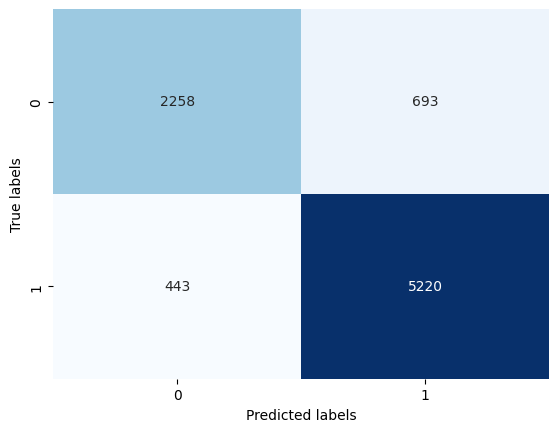

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [ ]:
test_size=8614
tp=(5220/test_size)*100
tn=(2258/test_size)*100
fp=(693/test_size)*100
fn=(443/test_size)*100
print(f"True positive: {tp}, True Negative: {tn}, False Positive: {fp}, False Negative:{fn}")

True positive: 59.948920362201065, True Negative: 27.16508010215928, False Positive: 7.093104248897145, False Negative:5.792895286742512
